In [105]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
%matplotlib inline

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, silhouette_score
from pandas.plotting import scatter_matrix
from sklearn.kernel_approximation import RBFSampler

# Data Preprocessing

In [106]:
# read data into a pandas dataframe
df = pd.read_csv("epl_dataset.csv")

# remove players that have had less than 19 appearances (half of a season)
df = df[df['Appearances'] >= 19]

# remove features that are not useful for the model/too similar to target variable
df = df.drop(['Name', 'Goals', 'Appearances', 'Headed goals', 'Goals with right foot', 'Goals with left foot',
            'Penalties scored', 'Freekicks scored'], axis=1)

# remove goalkeepers and defenders
df = df[~df['Position'].isin(['Goalkeeper', 'Defender'])]

# dummy variable encode the position, club, and nationality columns
df = pd.get_dummies(df, columns=['Position', 'Club', 'Nationality',], drop_first=True, dtype=int)

# list of columns that contain percentages
percentage_columns = ['Shooting accuracy %', 'Cross accuracy %', 'Tackle success %']
# convert all percentage columns to decimal values (0 to 1)
for column in percentage_columns:
    df[column] = df[column].str.replace('%', '').astype(float) / 100

# fill any missing values with 0
df.fillna(0, inplace=True)

# replace values greater than 1 in the goals per match column with 0
df['Goals per match'] = df['Goals per match'].apply(lambda x: 0 if x > 1 else x)

# save the modified dataset
df.to_csv("epl_data_linear_processed.csv", index=False)

In [107]:
# separate features (X) and target (y)
X = df.drop(columns=["Goals per match"])
y = df["Goals per match"]

# scale the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# print the shape of the scaled features and target
print("shape of X: ", X_scaled.shape)
print("shape of y: ", y.shape)

# split dataset into 60% training, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

shape of X:  (217, 112)
shape of y:  (217,)


# Visualizing Training Data

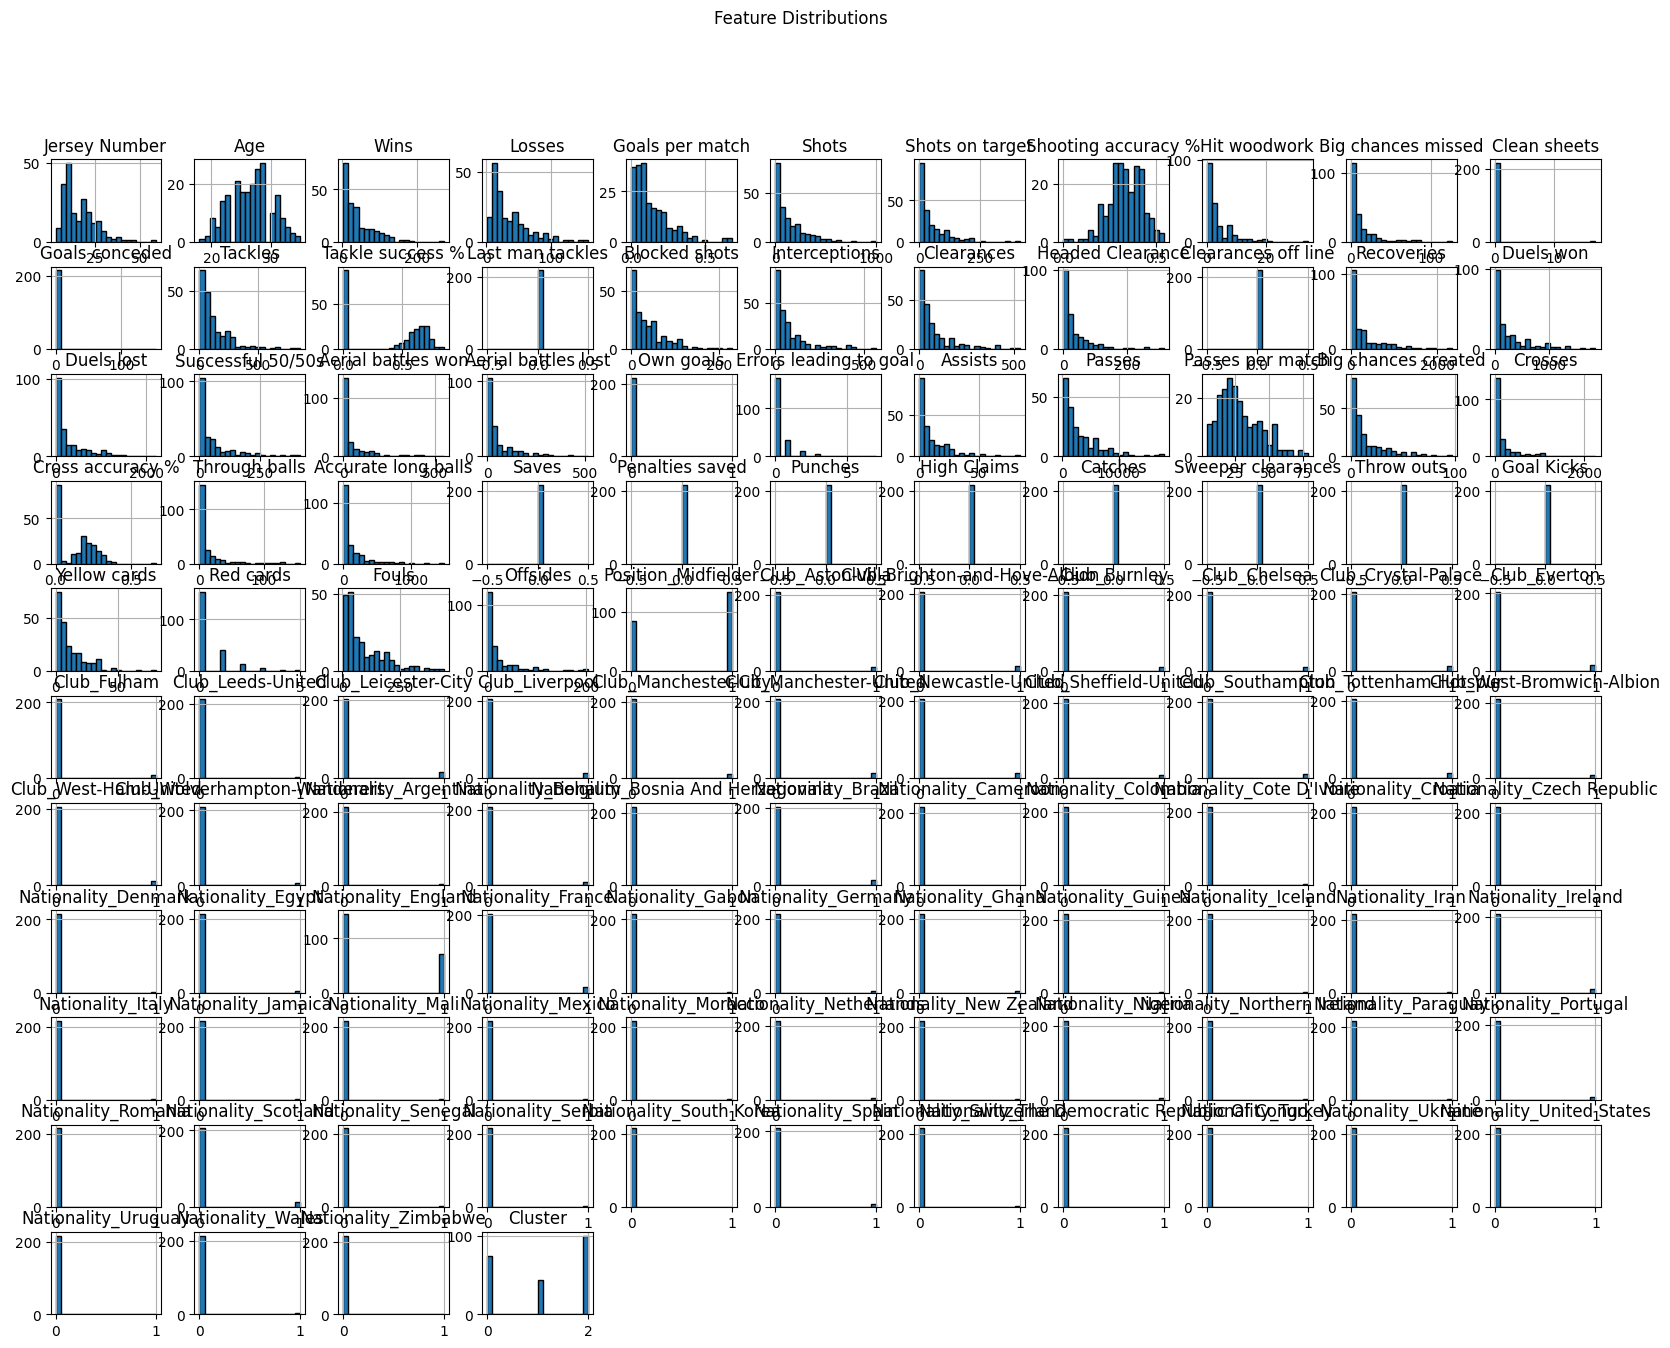

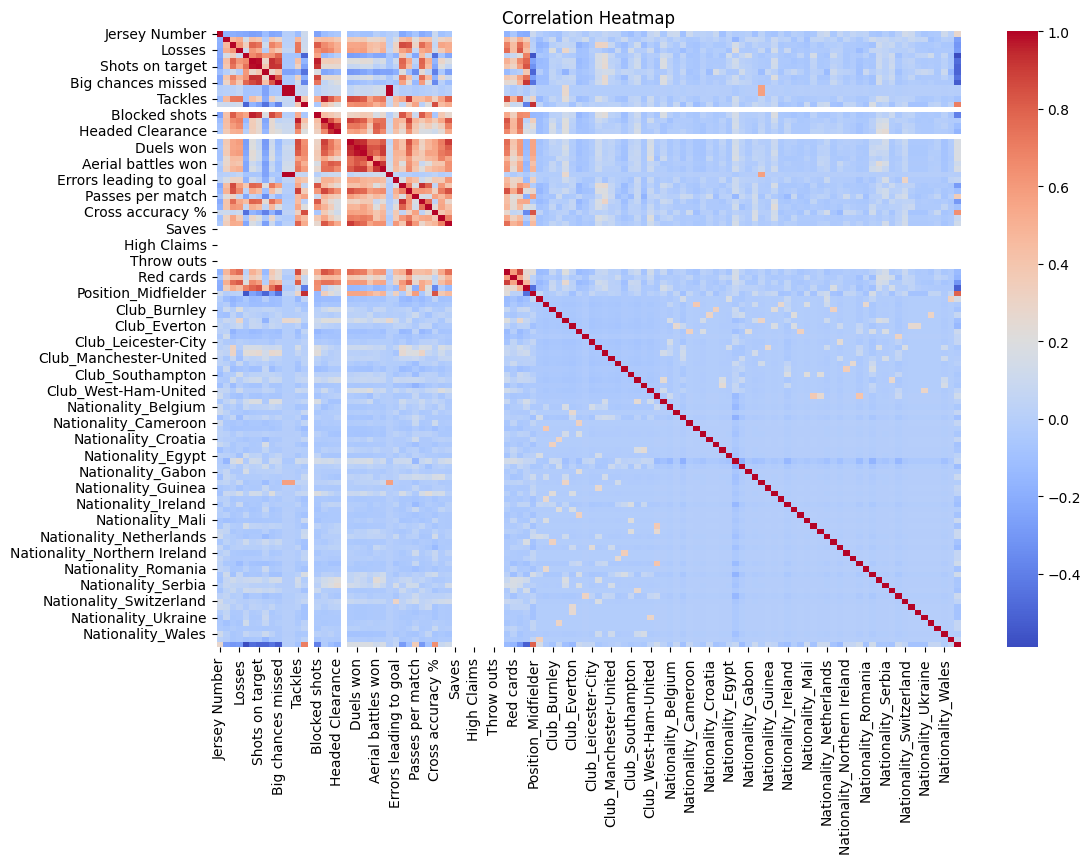

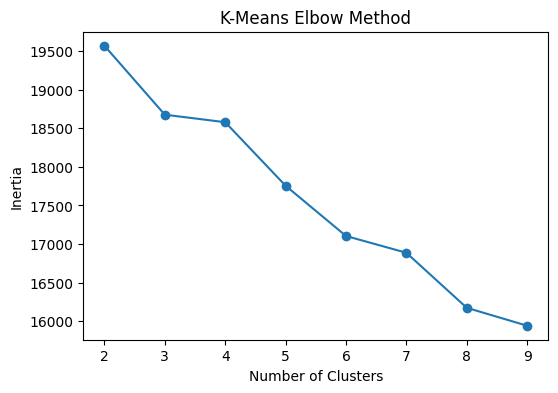

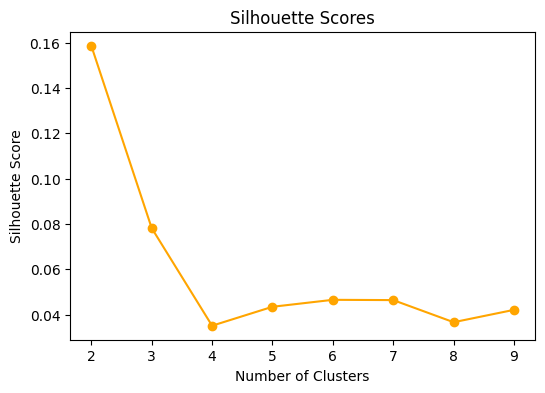

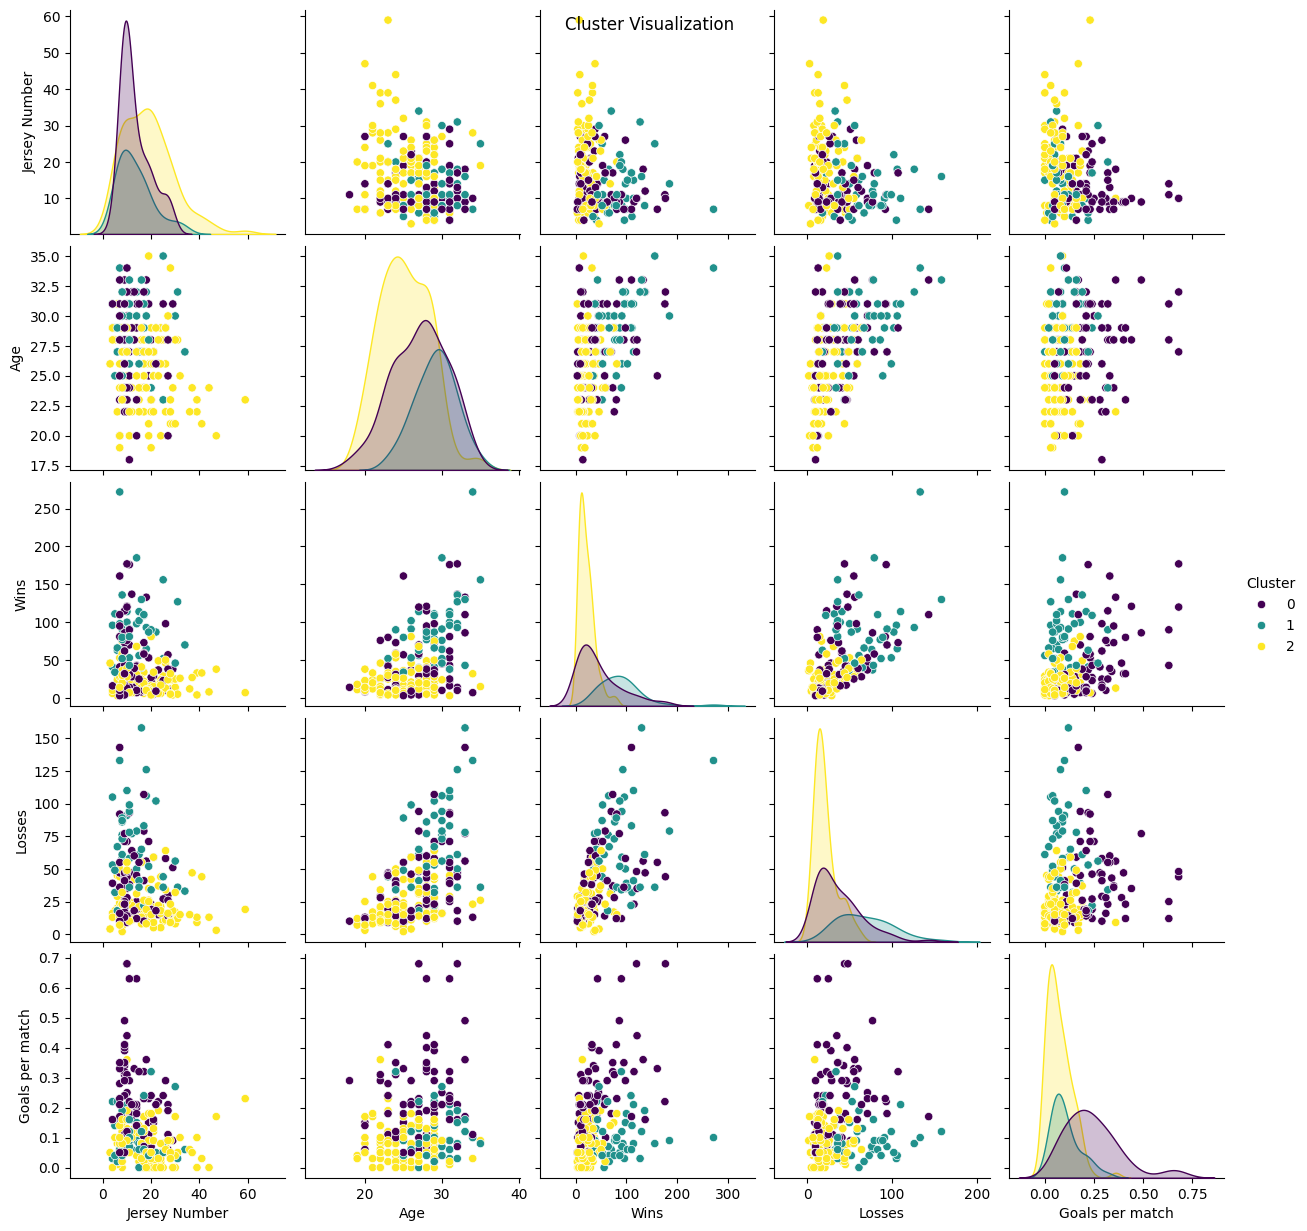

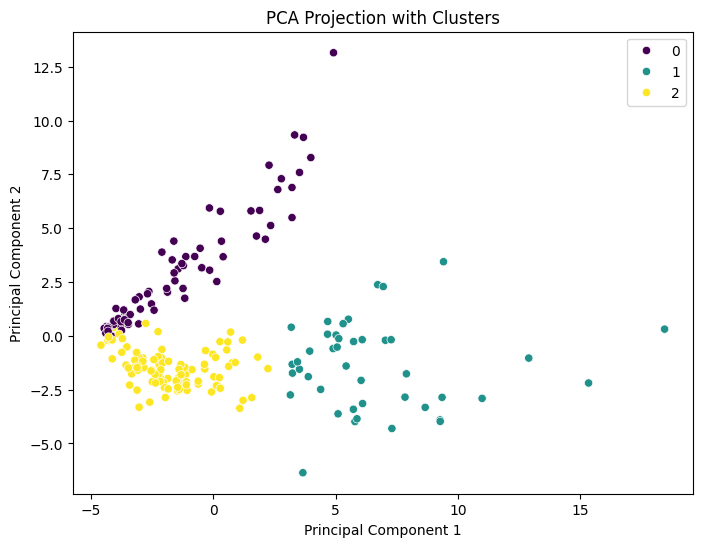

Explained variance ratio: [0.15772333 0.07854294]


In [110]:
# part 1: data visualization
# plot feature distributions
df.hist(figsize=(20, 15), bins=20, edgecolor='black')
plt.suptitle("Feature Distributions")
plt.show()

# plot relationship with target variable
# for column in df.columns:
#     if column != "Goals per match":
#         plt.figure(figsize=(6, 4))
#         sns.scatterplot(data=df, x=column, y="Goals per match")
#         plt.title(f"Feature: {column} vs Goals per match")
#         plt.show()

# correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# part 2: clustering
# perform K-Means clustering
inertia = []
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# plot inertia (elbow method)
plt.figure(figsize=(6, 4))
plt.plot(range(2, 10), inertia, marker='o')
plt.title("K-Means Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

# plot silhouette scores
plt.figure(figsize=(6, 4))
plt.plot(range(2, 10), silhouette_scores, marker='o', color='orange')
plt.title("Silhouette Scores")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

# choose the optimal number of clusters (e.g., k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
df["Cluster"] = kmeans.labels_

# visualize clusters
sns.pairplot(df, vars=df.columns[:5], hue="Cluster", palette="viridis")
plt.suptitle("Cluster Visualization")
plt.show()

# part 3: dimensionality reduction (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# visualize PCA-transformed data
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans.labels_, palette="viridis")
plt.title("PCA Projection with Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Linear Regression
* 3 Feature Transformations
* 6 Regularization Values

In [101]:
# function to evaluate models based on mean squared error
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_val_pred)
    print(f"MSE: {mse}")
    return mse

# initialize best MSE at a high value
curr_best_mse = 100

# polynomial transformation
print("\n-- polynomial transformation --")
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)

# try ridge and lasso regularization with 6 lambda values each
lambds = [0.001, 0.01, 0.1, 1, 10, 100]
for lambd in lambds:
    ridge = Ridge(alpha=lambd)
    lasso = Lasso(alpha=lambd, max_iter=10000)
    print(f"ridge (lambda={lambd}): ", end="")
    mse_poly_ridge = evaluate_model(ridge, X_train_poly, y_train, X_val_poly, y_val)
    if mse_poly_ridge < curr_best_mse:
        curr_best_mse = mse_poly_ridge
        best_model = "polynomial transformation + ridge regularization + lamda = " + str(lambd)
    print(f"lasso (lambda={lambd}): ", end="")
    mse_poly_lasso = evaluate_model(lasso, X_train_poly, y_train, X_val_poly, y_val)
    if mse_poly_lasso < curr_best_mse:
        curr_best_mse = mse_poly_lasso
        best_model = "polynomial transformation + lasso regularization + lamda = " + str(lambd)

# PCA transformation
print("\n-- PCA transformation --")
pca = PCA(n_components=min(X_train.shape[1], 10))  # Reduce to 10 components or less
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# try ridge and lasso regularization with 6 lambda values each
for lambd in lambds:
    ridge = Ridge(alpha=lambd)
    lasso = Lasso(alpha=lambd, max_iter=10000)
    print(f"ridge (lambda={lambd}): ", end="")
    mse_pca_ridge = evaluate_model(ridge, X_train_pca, y_train, X_val_pca, y_val)
    if mse_pca_ridge < curr_best_mse:
        curr_best_mse = mse_pca_ridge
        best_model = "PCA transformation + ridge regularization + lamda = " + str(lambd)
    print(f"lasso (lambda={lambd}): ", end="")
    mse_pca_lasso = evaluate_model(lasso, X_train_pca, y_train, X_val_pca, y_val)
    if mse_pca_lasso < curr_best_mse:
        curr_best_mse = mse_pca_lasso
        best_model = "PCA transformation + lasso regularization + lamda = " + str(lambd)

# RBF kernel transformation
print("\n-- RBF kernel transformation --")
rbf = RBFSampler(gamma=1, random_state=42, n_components=100)  # Map to 100 dimensions
X_train_rbf = rbf.fit_transform(X_train)
X_val_rbf = rbf.transform(X_val)

# try ridge and lasso regularization with 6 lambda values each
for lambd in lambds:
    ridge = Ridge(alpha=lambd)
    lasso = Lasso(alpha=lambd, max_iter=10000)
    print(f"ridge (lambda={lambd}): ", end="")
    mse_rbf_ridge = evaluate_model(ridge, X_train_rbf, y_train, X_val_rbf, y_val)
    if mse_rbf_ridge < curr_best_mse:
        curr_best_mse = mse_rbf_ridge
        best_model = "RBF transformation + ridge regularization + lamda = " + str(lambd)
    print(f"lasso (lambda={lambd}): ", end="")
    mse_rbf_lasso = evaluate_model(lasso, X_train_rbf, y_train, X_val_rbf, y_val)
    if mse_rbf_lasso < curr_best_mse:
        curr_best_mse = mse_rbf_lasso
        best_model = "RBF transformation + lasso regularization + lamda = " + str(lambd)

print("\nbest model:", best_model)



-- polynomial transformation --
ridge (lambda=0.001): MSE: 0.0112495617338579
lasso (lambda=0.001): MSE: 0.0036980770686915057
ridge (lambda=0.01): MSE: 0.011249511020838812
lasso (lambda=0.01): MSE: 0.003431089031908717
ridge (lambda=0.1): MSE: 0.011249003795191613
lasso (lambda=0.1): MSE: 0.009129184976837904
ridge (lambda=1): MSE: 0.011243922265446253
lasso (lambda=1): MSE: 0.010817206962983349
ridge (lambda=10): MSE: 0.011192417555837426
lasso (lambda=10): MSE: 0.010817206962983349
ridge (lambda=100): MSE: 0.010698428258803398
lasso (lambda=100): MSE: 0.010817206962983349

-- PCA transformation --
ridge (lambda=0.001): MSE: 0.003801274252987386
lasso (lambda=0.001): MSE: 0.003795736350988465
ridge (lambda=0.01): MSE: 0.0038012820720790623
lasso (lambda=0.01): MSE: 0.0038210007614636883
ridge (lambda=0.1): MSE: 0.003801360330478096
lasso (lambda=0.1): MSE: 0.005008488239691105
ridge (lambda=1): MSE: 0.003802149637903721
lasso (lambda=1): MSE: 0.010817206962983349
ridge (lambda=10):

In [99]:
# final evaluation on test set using best model from validation set
# best model: polynomial transformation + lasso regularization + lamda = 0.01
best_transformation = X_train_poly
best_val_transformation = X_val_poly
best_test_transformation = poly.transform(X_test)
best_model = Lasso(alpha=0.01)

best_model.fit(best_transformation, y_train)
y_test_pred = best_model.predict(best_test_transformation)
final_mse = mean_squared_error(y_test, y_test_pred)
final_r2 = best_model.score(best_test_transformation, y_test)
print("final test MSE:", final_mse)
print("final test R^2:", final_r2)

final test MSE: 0.0053006490034206415
final test R^2: 0.6662908648156234


# Ignore the rest

In [92]:
# separate features (X) and target (y)
X = df.drop(columns=["Goals per match"])
y = df["Goals per match"]
# print("shape of X: ", X_scaled.shape)
# print("shape of y: ", y.shape)

# fit and transform the feature data using standard scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split dataset into 60% training, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# initialize variables to track the best number of features
curr_min = 100
best_k = 0

# iterate over all possible feature counts
for k in range(1, X.shape[1] + 1):  # loop through all possible numbers of features
    # select top-k features using the training data
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)

    # train the linear regression model
    model = LinearRegression()
    model.fit(X_train_selected, y_train)

    # evaluate on the validation set
    y_val_pred = model.predict(X_val_selected)
    mse = mean_squared_error(y_val, y_val_pred)
    print(f"k={k}, Validation Mean Squared Error: {mse}")

    # update the best number of features (k)
    if mse < curr_min:
        curr_min = mse
        best_k = k

# refit the selector and model with the best k on the combined training + validation set
selector = SelectKBest(score_func=f_regression, k=best_k)
X_train_val = np.vstack([X_train, X_val])
y_train_val = np.hstack([y_train, y_val])
X_train_val_selected = selector.fit_transform(X_train_val, y_train_val)
X_test_selected = selector.transform(X_test)

# get the selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)

# train the model on the final training set
final_model = LinearRegression()
final_model.fit(X_train_val_selected, y_train_val)

# evaluate the model on the test set
y_test_pred = final_model.predict(X_test_selected)
final_mse = mean_squared_error(y_test, y_test_pred)
print(f"Best k: {best_k}")
print(f"Test Mean Squared Error: {final_mse}")



shape of X:  (217, 112)
shape of y:  (217,)
k=1, Validation Mean Squared Error: 0.003040703008986282
k=2, Validation Mean Squared Error: 0.0030450354762093035
k=3, Validation Mean Squared Error: 0.0031161692840815064
k=4, Validation Mean Squared Error: 0.002547002095038764
k=5, Validation Mean Squared Error: 0.002530701911487364
k=6, Validation Mean Squared Error: 0.0025024022408492996
k=7, Validation Mean Squared Error: 0.002231315564127025
k=8, Validation Mean Squared Error: 0.002193131739957323
k=9, Validation Mean Squared Error: 0.0022024018955567447
k=10, Validation Mean Squared Error: 0.002267552145903364
k=11, Validation Mean Squared Error: 0.0024358461895298976
k=12, Validation Mean Squared Error: 0.0024464649635158008
k=13, Validation Mean Squared Error: 0.0024539579616649
k=14, Validation Mean Squared Error: 0.002456271772085341
k=15, Validation Mean Squared Error: 0.0024844241366753675
k=16, Validation Mean Squared Error: 0.002473787396982503
k=17, Validation Mean Squared Er

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:379: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)


In [71]:
# separate features (X) and target (y)
X = df.drop(columns=["Goals per match"])
y = df["Goals per match"]

# initialize the scaler
scaler = StandardScaler()

# fit and transform the feature data
X_scaled = scaler.fit_transform(X)

# split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

curr_min = 100
for k in range(1, X.shape[1] + 1):  # Loop through all possible feature counts
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_pred)
    print(f"k={k}, Mean Squared Error: {mse}")
    curr_min = min(mse)

# apply SelectKBest to select top 5 features based on f_regression
selector = SelectKBest(score_func=f_regression, k=curr_min)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get selected feature names
selected_features = X_train.columns[selector.get_support()]
print("Selected Features:", selected_features)

# Train linear regression model on selected features
model = LinearRegression()
model.fit(X_train_selected, y_train)

# Make predictions
y_pred = model.predict(X_test_selected)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)



Selected Features: Index(['Shots', 'Shots on target', 'Shooting accuracy %', 'Hit woodwork',
       'Big chances missed', 'Blocked shots', 'Offsides',
       'Position_Midfielder'],
      dtype='object')
Mean Squared Error: 0.002711139118674995
k=1, Mean Squared Error: 0.004499763496554159
k=2, Mean Squared Error: 0.004295999587945544
k=3, Mean Squared Error: 0.0042177279385378075
k=4, Mean Squared Error: 0.003384186014861989
k=5, Mean Squared Error: 0.003354043987327593
k=6, Mean Squared Error: 0.0029544600674982577
k=7, Mean Squared Error: 0.0027156780935213456
k=8, Mean Squared Error: 0.002711139118674995
k=9, Mean Squared Error: 0.002875670795156948
k=10, Mean Squared Error: 0.0029029393656580717
k=11, Mean Squared Error: 0.0029858213568755717
k=12, Mean Squared Error: 0.002898667405726566
k=13, Mean Squared Error: 0.002989821262004122
k=14, Mean Squared Error: 0.0031635518789855017
k=15, Mean Squared Error: 0.0031667628225688425
k=16, Mean Squared Error: 0.0031515507193983746
k=17

In [ ]:
# remove features that only apply to goalkeepers, defenders (and midfielders)
# df = df.drop(['Saves', 'Penalties saved', 'Punches', 'High Claims', 'Catches', 'Sweeper clearances', 'Throw outs', 'Goal Kicks', 'Clean sheets', 
#               'Goals conceded', 'Tackle success %', 'Last man tackles', 'Clearances off line', 'Recoveries', 'Crosses', 'Duels won', 'Duels lost', 
#               'Successful 50/50s', 'Aerial battles won', 'Aerial battles lost', 'Own goals', 'Errors leading to goal', 'Cross accuracy %', 
#               'Through balls', 'Accurate long balls'], axis=1)

# remove features that are clearly attacking related/irrelevant
# df = df.drop(['Headed goals', 'Goals with right foot', 'Goals with left foot', 'Penalties scored', 'Freekicks scored', 'Shots', 'Shots on target', 
              #'Shooting accuracy %', 'Hit woodwork', 'Big chances missed', 'Offsides', 'Big chances created', 'Blocked shots', 'Wins', 'Losses'], axis = 1)

#remove features that are clearly defensive related/irrelevant
# df = df.drop(['Age', 'Tackles', 'Interceptions', 'Clearances', 'Headed Clearance', 'Assists', 'Passes', 
#               'Passes per match', 'Yellow cards', 'Red cards', 'Fouls'], axis=1)

In [ ]:
df = pd.read_csv("epl_dataset.csv")
scatter_matrix(df, figsize=(12, 8))
plt.show()

# Linear Regression
Predict Goals per game based on Age, Tackles, Interceptions, Clearances, Headed Clearance, Assists, Passes, Passes per match, Yellow cards, Red cards, Fouls, and Position (between forward and midfielder).

In [53]:
# separate features and target variable
X = df.drop(['Goals per match'], axis=1) # features
y = df['Goals per match'] # target variable

# initialize the scaler
scaler = StandardScaler()

# fit and transform the feature data
X_scaled = scaler.fit_transform(X)

#print("shape of X: ", X_scaled.shape)  # we have 217 examples and 12 features
#print("shape of y: ", y.shape)

# split data into 20% test and 80% train
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (173, 16)
X_test shape: (44, 16)
y_train shape: (173,)
y_test shape: (44,)


In [54]:
# append column of ones to X_scaled
N = X_scaled.shape[0]
ones = np.ones((N,1))
X_1 =  np.hstack((ones, X_scaled))

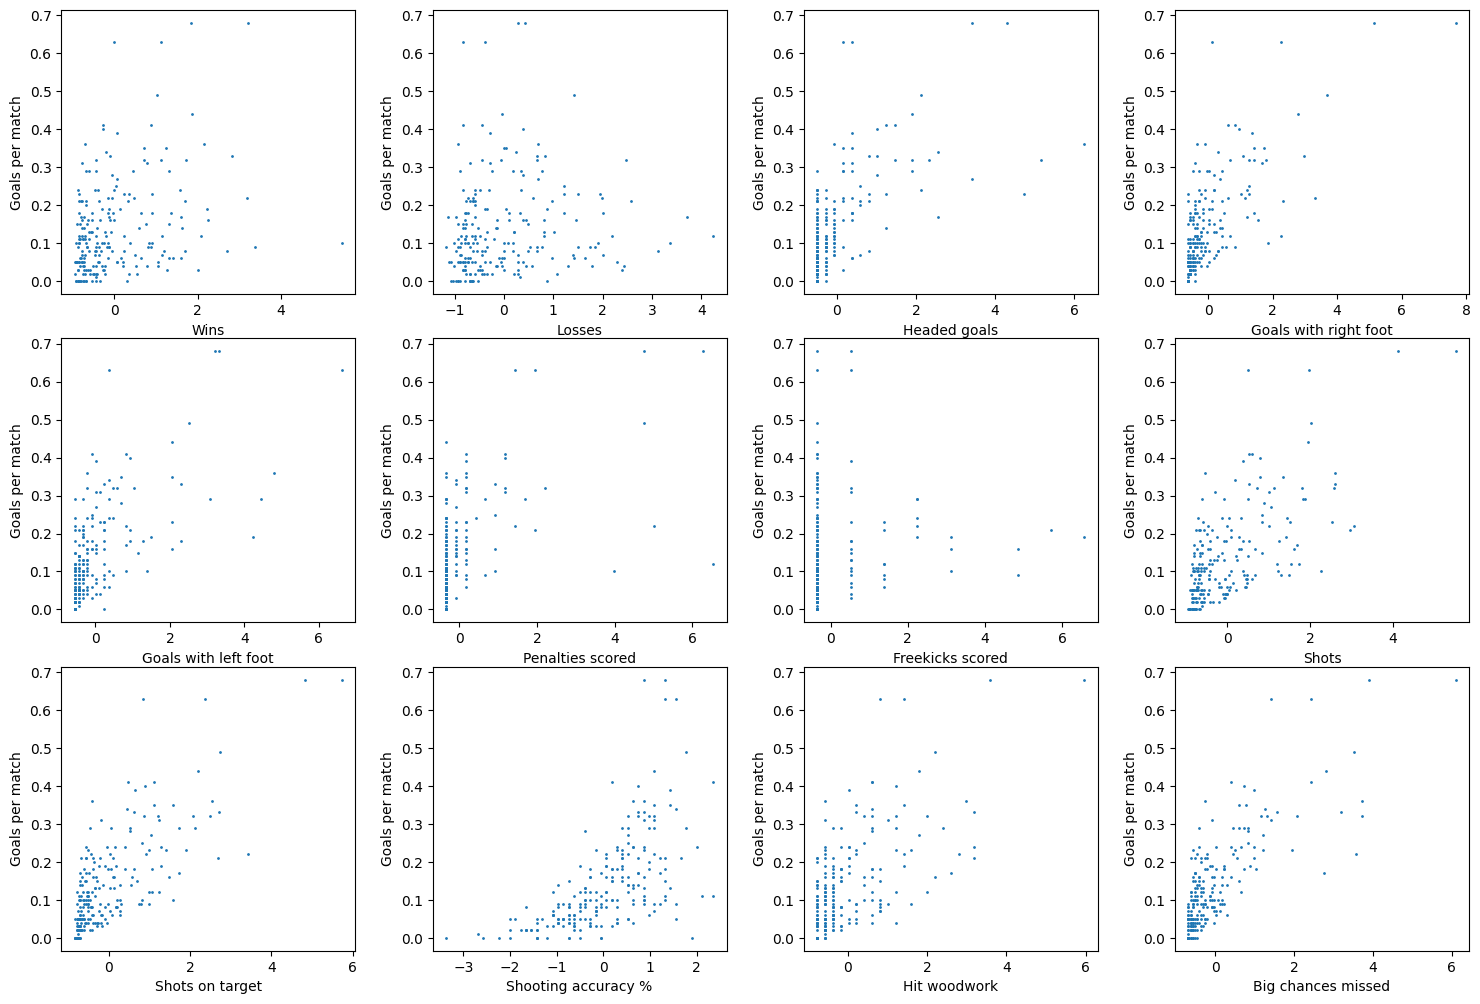

In [55]:
fig, axs = plt.subplots(3, 4, figsize=(15,10)) 
for ax in axs.flat:
    ax.set( ylabel='Goals per match')
    
fig.tight_layout()

feature_names = X.columns
for i in range (3):
    for j in range (4):
        axs[i, j].scatter(X_1[:,i*4+j+1],y, s=1)
        axs[i, j].set_xlabel(feature_names[i*4+j])